In [36]:
!pip install category_encoders
!pip install scikit-learn
!pip install scikit-optimize

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Load the diamonds dataset
data = pd.read_csv("datasets/diamonds.csv")

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('price')

# Preprocessing
# Label encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# One-hot encode categorical features
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Split data into train and test sets
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the naive XGBoost model
naive_model = XGBRegressor(random_state=42)
naive_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_naive = naive_model.predict(X_test)

# Calculate metrics
naive_rmse = np.sqrt(mean_squared_error(y_test, y_pred_naive))
naive_r2 = r2_score(y_test, y_pred_naive)
naive_mae = mean_absolute_error(y_test, y_pred_naive)
naive_mape = mean_absolute_percentage_error(y_test, y_pred_naive) * 100

print("Naive Model Metrics:")
print("RMSE:", naive_rmse)
print("R^2:", naive_r2)
print("MAE:", naive_mae)
print("MAPE:", naive_mape)


Naive Model Metrics:
RMSE: 56.52324259209657
R^2: 0.9997990131378174
MAE: 26.23485565185547
MAPE: 1.5203889459371567


In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


# 1. Load and Preprocess Data
data = pd.read_csv("datasets/diamonds.csv")

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('price')  # Remove the target variable

# Preprocessing
# Label encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Scale numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Split data into train and test sets
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2. Build Entity Embeddings Model (Keras)
categorical_inputs = []
embedding_outputs = []
embedding_feature_names = []

for col in categorical_cols:
    # Input layer for the categorical column
    cat_input = keras.Input(shape=(1,), name=col)
    categorical_inputs.append(cat_input)

    # Determine the number of unique values for embedding size
    num_unique_values = data[col].nunique()
    embedding_dim = int(min(np.ceil(num_unique_values / 2), 50))  # Adjust as needed

    # Create embedding layer
    embedding_layer = layers.Embedding(input_dim=num_unique_values + 1, output_dim=embedding_dim, name=col + '_embedding')(cat_input)

    # Flatten the embedding layer
    embedding_output = layers.Flatten()(embedding_layer)
    embedding_outputs.append(embedding_output)

    # Update embedding feature names
    embedding_feature_names.extend([f"{col}_emb_{i}" for i in range(embedding_dim)])

# Concatenate embeddings and numerical features
all_embeddings = layers.concatenate(embedding_outputs)
numerical_input = keras.Input(shape=(len(numerical_cols),), name='numerical_features')
merged_features = layers.concatenate([all_embeddings, numerical_input])

hidden_layer = layers.Dense(64, activation='relu')(merged_features)  # Adjust as needed
output_layer = layers.Dense(1, activation='linear')(hidden_layer)

embedding_model_full = keras.Model(inputs=categorical_inputs + [numerical_input], outputs=output_layer)
embedding_model_full.compile(optimizer='adam', loss='mse', metrics=['mae'])


# 3. Train Keras Entity Embeddings Model
cat_train_inputs = [X_train[col].values.reshape(-1, 1) for col in categorical_cols]
cat_test_inputs = [X_test[col].values.reshape(-1, 1) for col in categorical_cols]

embedding_model_full.fit(
    cat_train_inputs + [X_train[numerical_cols]],
    y_train,
    epochs=50,  # Adjust epochs
    batch_size=32  # Adjust batch size
)


# 4. Extract Embeddings
embedding_extractor = keras.Model(inputs=categorical_inputs, outputs=all_embeddings)
X_train_emb = embedding_extractor.predict(cat_train_inputs)
X_test_emb = embedding_extractor.predict(cat_test_inputs)


# 5. Apply PCA to Embeddings
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
X_train_emb_pca = pca.fit_transform(X_train_emb)
X_test_emb_pca = pca.transform(X_test_emb)

# Create PCA feature names
pca_feature_names = [f"PC{i+1}" for i in range(X_train_emb_pca.shape[1])]


# 6. Combine Embeddings with Numerical Features
X_train_final = np.concatenate([X_train_emb_pca, X_train[numerical_cols].values], axis=1)
X_test_final = np.concatenate([X_test_emb_pca, X_test[numerical_cols].values], axis=1)

# Create final feature names list
all_feature_names = pca_feature_names + numerical_cols

# 7. Train XGBoost Model
xgb_model = XGBRegressor(random_state=42)  # You can add hyperparameters here
xgb_model.fit(X_train_final, y_train)


# 8. Predictions and Evaluation
y_pred_emb = xgb_model.predict(X_test_final)

# Calculate metrics
emb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_emb))
emb_r2 = r2_score(y_test, y_pred_emb)
emb_mae = mean_absolute_error(y_test, y_pred_emb)
emb_mape = mean_absolute_percentage_error(y_test, y_pred_emb) * 100

print("\nEmbedded Model Metrics:")
print("RMSE:", emb_rmse)
print("R^2:", emb_r2)
print("MAE:", emb_mae)
print("MAPE:", emb_mape)

Epoch 1/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 27814054.0000 - mae: 3564.5884
Epoch 2/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 11017894.0000 - mae: 2430.8345
Epoch 3/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 7311534.5000 - mae: 1888.4733
Epoch 4/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 4318053.0000 - mae: 1353.9127
Epoch 5/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3081265.0000 - mae: 1157.8099
Epoch 6/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2314535.5000 - mae: 1077.8162
Epoch 7/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1827185.7500 - mae: 961.0692
Epoch 8/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1587071.0000 - mae: 873.4926
Epoch 9/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1381552.3750 - mae: 801.5079
Epoch 10/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1213937.1250 - mae: 694.1335
Epoch 11/50
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1159108.2500 - m

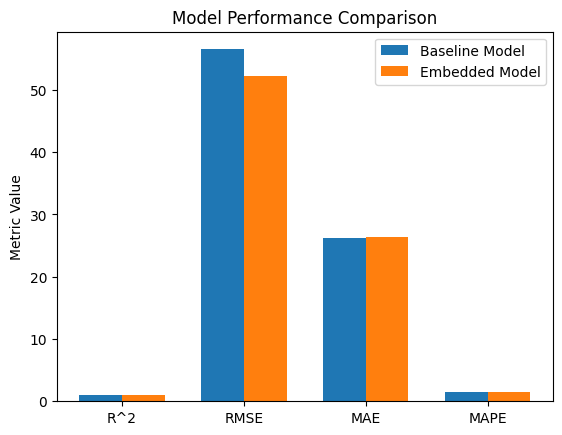

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Naive Model Metrics:
# RMSE: 56.52324259209657
# R^2: 0.9997990131378174
# MAE: 26.23485565185547
# MAPE: 1.5203889459371567
# Baseline model metrics
baseline_metrics = {
    'R^2': 0.9997990131378174,
    'RMSE': 56.52324259209657,
    'MAE': 26.23485565185547,
    'MAPE': 1.5203889459371567
}


# Embedded Model Metrics:
# RMSE: 51.83516448651196
# R^2: 0.999830961227417
# MAE: 26.760595321655273
# MAPE: 1.5228882431983948
# Improved model metrics
improved_metrics = {
    'R^2':  0.9998279213905334,
    'RMSE': 52.29902940363712,
    'MAE': 26.380884170532227,
    'MAPE': 1.4832939021289349,
}

# Metric names for the x-axis
metrics = list(baseline_metrics.keys())

# Metric values for the baseline and improved models
baseline_values = list(baseline_metrics.values())
improved_values = list(improved_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots()

# Bars for the baseline model
baseline_bars = ax.bar(np.arange(len(metrics)), baseline_values, bar_width, label='Baseline Model')

# Bars for the improved model
improved_bars = ax.bar(np.arange(len(metrics)) + bar_width, improved_values, bar_width, label='Embedded Model')

# Set the x-axis labels and tick positions
ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the title of the chart
ax.set_title('Model Performance Comparison')

# Add a legend
ax.legend()

# Display the chart
plt.show()

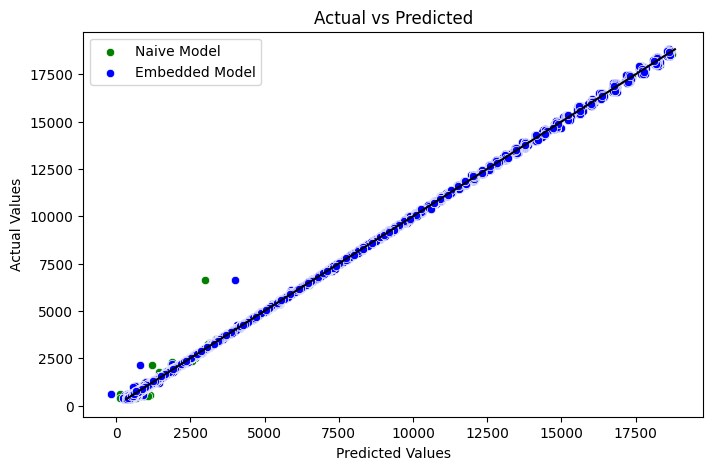

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatterplot for actual vs predicted values
fig, ax = plt.subplots(figsize=(8, 5))

# Plot naive model results in green
sns.scatterplot(x=y_pred_naive, y=y_test, ax=ax, color='green', label='Naive Model')

# Plot embedded model results in blue
sns.scatterplot(x=y_pred_emb, y=y_test, ax=ax, color='blue', label='Embedded Model')

# Plot the ideal line (y = x) in black
sns.lineplot(x=y_test, y=y_test, ax=ax, color='black')  # Changed to y_test for x and y

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Actual vs Predicted')
ax.legend()

plt.show()

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from itertools import product

# Load the flight data (assuming it's in a file called 'flight_data.csv')
data = pd.read_csv("datasets/economy.csv")

# Identify categorical and numerical columns
categorical_cols = ['airline', 'ch_code', 'from', 'to', 'stop']
numerical_cols = []  # Initialize numerical_cols as empty

# Function to convert time to numeric representation
def time_to_numeric(time_str):
    """Converts a time string (HH:MM) to a numeric value between 0 and 10."""
    try:
        hours, minutes = map(int, time_str.split(':'))
        total_minutes = hours * 60 + minutes
        numeric_value = total_minutes / (24 * 60) * 10
        return numeric_value
    except ValueError:
        return None  # Handle invalid time strings (if any)

# Function to convert duration to minutes
def duration_to_minutes(duration_str):
    """Converts a duration string (e.g., '2h 10m') to total minutes."""
    try:
        hours = int(duration_str.split('h')[0]) if 'h' in duration_str else 0
        minutes = int(duration_str.split('h')[1].split('m')[0]) if 'm' in duration_str else 0
        total_minutes = hours * 60 + minutes
        return total_minutes
    except (ValueError, IndexError):
        return None  # Handle invalid duration strings

# Preprocessing
# Remove commas and convert 'price' to numeric
data['price'] = data['price'].str.replace(',', '').astype(float)

# Label encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Convert time columns to numerical representations
data['dep_time_numeric'] = data['dep_time'].apply(time_to_numeric)
data['arr_time_numeric'] = data['arr_time'].apply(time_to_numeric)

# Convert duration to minutes and add it to numerical_cols
data['time_taken_minutes'] = data['time_taken'].apply(duration_to_minutes)
numerical_cols.append('time_taken_minutes')

# Update numerical_cols to include the new numeric time columns
numerical_cols.extend(['dep_time_numeric', 'arr_time_numeric'])

# Drop the original time and duration columns (Moved before scaling)
data = data.drop(['dep_time', 'arr_time', 'time_taken'], axis=1)

# Convert 'date' to ordinal numbers using LabelEncoder
le_date = LabelEncoder()
data['date_encoded'] = le_date.fit_transform(data['date'])

# Drop the original 'date' column
data = data.drop(['date'], axis=1)  # Drop 'date' after encoding

# Scale numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Split data into train and test sets
X = data.drop('price', axis=1)  # Features (all columns except 'price')
y = data['price']  # Target variable ('price')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the naive XGBoost model
naive_model = XGBRegressor(random_state=42)
naive_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_naive = naive_model.predict(X_test)

# Calculate metrics
naive_rmse = np.sqrt(mean_squared_error(y_test, y_pred_naive))
naive_r2 = r2_score(y_test, y_pred_naive)
naive_mae = mean_absolute_error(y_test, y_pred_naive)
naive_mape = mean_absolute_percentage_error(y_test, y_pred_naive) * 100

print("Naive Model Metrics:")
print("RMSE:", naive_rmse)
print("R^2:", naive_r2)
print("MAE:", naive_mae)
print("MAPE:", naive_mape)

Naive Model Metrics:
RMSE: 1663.153562351356
R^2: 0.8012730280432387
MAE: 1040.8660572128101
MAPE: 16.682746037079525


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Load the flight data
data = pd.read_csv("datasets/economy.csv")

# Preprocessing: Remove commas and convert 'price' to numeric
data['price'] = data['price'].str.replace(',', '').astype(float)

# Improved function to convert time to numeric representation with error handling
def time_to_numeric(time_str):
    try:
        if pd.isna(time_str) or time_str is None:
            return np.nan  # We'll handle NaNs with imputation later
        hours, minutes = map(int, time_str.split(':'))
        total_minutes = hours * 60 + minutes
        numeric_value = total_minutes / (24 * 60) * 10
        return numeric_value
    except (ValueError, AttributeError):
        return np.nan

# Improved function to convert duration to minutes with error handling
def duration_to_minutes(duration_str):
    try:
        if pd.isna(duration_str) or duration_str is None:
            return np.nan  # We'll handle NaNs with imputation later
        hours = int(duration_str.split('h')[0]) if 'h' in duration_str else 0
        minutes = int(duration_str.split('h')[1].split('m')[0]) if 'm' in duration_str and 'h' in duration_str else 0
        if 'm' in duration_str and 'h' not in duration_str:
            minutes = int(duration_str.split('m')[0])
        total_minutes = hours * 60 + minutes
        return total_minutes
    except (ValueError, IndexError, AttributeError):
        return np.nan

# Preprocessing: Convert time and duration columns
data['dep_time_numeric'] = data['dep_time'].apply(time_to_numeric)
data['arr_time_numeric'] = data['arr_time'].apply(time_to_numeric)
data['time_taken_minutes'] = data['time_taken'].apply(duration_to_minutes)

# Check for NaNs in time features
print("NaN counts in time features:")
print(data['dep_time_numeric'].isna().sum(), "NaNs in dep_time_numeric")
print(data['arr_time_numeric'].isna().sum(), "NaNs in arr_time_numeric")
print(data['time_taken_minutes'].isna().sum(), "NaNs in time_taken_minutes")

# Impute missing values in numerical columns
numerical_imputer = SimpleImputer(strategy='median')
numerical_cols = ['time_taken_minutes', 'dep_time_numeric', 'arr_time_numeric']
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])

# Identify categorical columns
categorical_cols = ['airline', 'ch_code', 'from', 'to', 'stop', 'date']

# Handle missing values in categorical features if any
for col in categorical_cols:
    data[col] = data[col].fillna("Unknown")  # Fill missing values with "Unknown"

# Label encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Split the data
X = data[categorical_cols + numerical_cols]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for entity embeddings
# Extract categorical features for embedding
X_train_cat = [X_train[col].values.reshape(-1, 1) for col in categorical_cols]
X_test_cat = [X_test[col].values.reshape(-1, 1) for col in categorical_cols]

# Extract numerical features
X_train_num = X_train[numerical_cols].values
X_test_num = X_test[numerical_cols].values

# Entity Embeddings with Keras
categorical_inputs = []
embedding_outputs = []

for col in categorical_cols:
    cat_input = keras.Input(shape=(1,), name=col)
    categorical_inputs.append(cat_input)
    num_unique_values = data[col].nunique()
    embedding_dim = int(min(np.ceil(num_unique_values / 2), 50))
    embedding_layer = layers.Embedding(input_dim=num_unique_values + 1, output_dim=embedding_dim, name=col + '_embedding')(cat_input)
    embedding_output = layers.Flatten()(embedding_layer)
    embedding_outputs.append(embedding_output)

# Concatenate embeddings and numerical features
all_embeddings = layers.concatenate(embedding_outputs)
numerical_input = keras.Input(shape=(len(numerical_cols),), name='numerical_features')
merged_features = layers.concatenate([all_embeddings, numerical_input])

# Define the model
hidden_layer = layers.Dense(64, activation='relu')(merged_features)
output_layer = layers.Dense(1, activation='linear')(hidden_layer)
embedding_model = keras.Model(inputs=categorical_inputs + [numerical_input], outputs=output_layer)
embedding_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the embedding model
embedding_model.fit(
    X_train_cat + [X_train_num],
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1  # Set to 1 to see training progress
)

# Extract embeddings
embedding_extractor = keras.Model(inputs=categorical_inputs, outputs=all_embeddings)
X_train_emb = embedding_extractor.predict(X_train_cat)
X_test_emb = embedding_extractor.predict(X_test_cat)

# Check for NaNs in embeddings
print("NaN count in embeddings:", np.isnan(X_train_emb).sum())

# If NaNs exist in embeddings, impute them
if np.isnan(X_train_emb).sum() > 0:
    print("Imputing NaN values in embeddings...")
    embedding_imputer = SimpleImputer(strategy='mean')
    X_train_emb = embedding_imputer.fit_transform(X_train_emb)
    X_test_emb = embedding_imputer.transform(X_test_emb)

# Apply PCA to embeddings (now without NaNs)
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
X_train_emb_pca = pca.fit_transform(X_train_emb)
X_test_emb_pca = pca.transform(X_test_emb)

# Combine PCA-transformed embeddings with numerical features
X_train_final = np.concatenate([X_train_emb_pca, X_train_num], axis=1)
X_test_final = np.concatenate([X_test_emb_pca, X_test_num], axis=1)

# Train XGBoost on embeddings
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_final, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_final)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nEmbeddings Model Metrics:")
print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)
print("MAPE:", mape)

NaN counts in time features:
0 NaNs in dep_time_numeric
0 NaNs in arr_time_numeric
4 NaNs in time_taken_minutes
Epoch 1/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 20094682.0000 - mae: 3173.3787
Epoch 2/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 5268945.0000 - mae: 1537.4609
Epoch 3/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 4985518.5000 - mae: 1484.6411
Epoch 4/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 4869197.0000 - mae: 1466.2626
Epoch 5/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 4830655.5000 - mae: 1448.3175
Epoch 6/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 4804308.0000 - mae: 1443.1829
Epoch 7/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4792184.5000 - mae: 1440.2471
Epoch 8/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4750156.5000 - mae: 1434.0713
Epoch 9/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 4722220.0000 - mae: 1430.0903
Epoch 10/50
5170/5170 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms

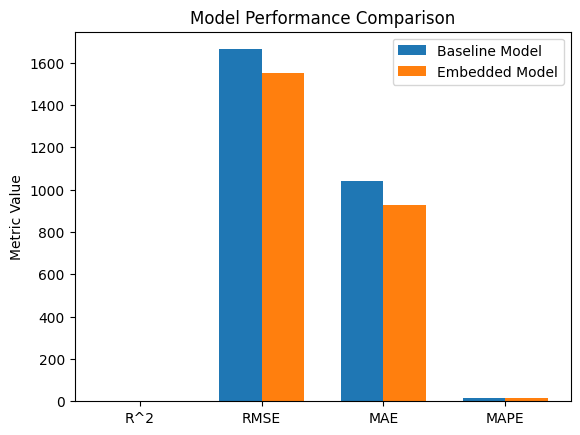

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Naive Model Metrics:
# RMSE: 1663.153562351356
# R^2: 0.8012730280432387
# MAE: 1040.8660572128101
# MAPE: 16.682746037079525
# Baseline model metrics
baseline_metrics = {
    'R^2': 0.8012730280432387,
    'RMSE': 1663.153562351356,
    'MAE': 1040.8660572128101,
    'MAPE': 16.682746037079525
}

# Embeddings Model Metrics:
# RMSE: 1550.3887647151337
# R^2: 0.8273075545721215
# MAE: 927.2097399682438
# MAPE: 14.51833243956677
# Embeddings model metrics
improved_metrics = {
    'R^2': 0.8273075545721215,
    'RMSE':  1550.3887647151337,
    'MAE': 927.2097399682438,
    'MAPE': 14.51833243956677,
}

# Metric names for the x-axis
metrics = list(baseline_metrics.keys())

# Metric values for the baseline and improved models
baseline_values = list(baseline_metrics.values())
improved_values = list(improved_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots()

# Bars for the baseline model
baseline_bars = ax.bar(np.arange(len(metrics)), baseline_values, bar_width, label='Baseline Model')

# Bars for the improved model
improved_bars = ax.bar(np.arange(len(metrics)) + bar_width, improved_values, bar_width, label='Embedded Model')

# Set the x-axis labels and tick positions
ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the title of the chart
ax.set_title('Model Performance Comparison')

# Add a legend
ax.legend()

# Display the chart
plt.show()

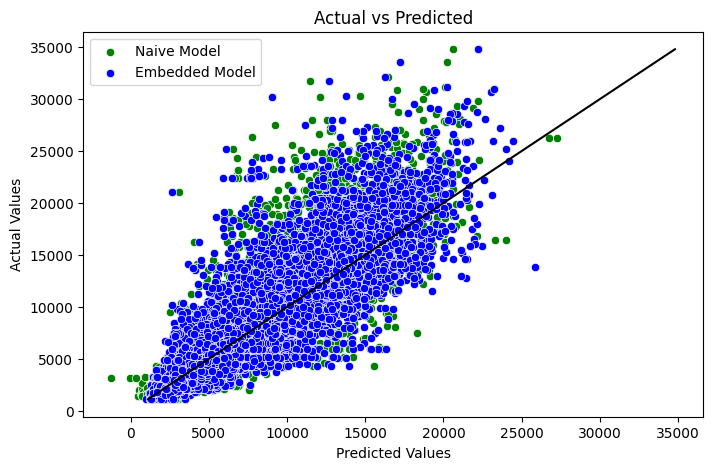

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatterplot for actual vs predicted values
fig, ax = plt.subplots(figsize=(8, 5))

# Plot naive model results in green
sns.scatterplot(x=y_pred_naive, y=y_test, ax=ax, color='green', label='Naive Model')

# Plot embedded model results in blue
sns.scatterplot(x=y_pred, y=y_test, ax=ax, color='blue', label='Embedded Model')

# Plot the ideal line (y = x) in black
sns.lineplot(x=y_test, y=y_test, ax=ax, color='black')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Actual vs Predicted')
ax.legend()

plt.show()

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

# 1. Load the dataset:
data = pd.read_csv("datasets/Restaurant_revenue.csv")

# 2. Identify categorical and numerical columns:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('Monthly_Revenue') # Remove target variable from numerical features

# 3. Preprocessing:
#   - Label encode categorical features:
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

#   - One-hot encode categorical features:
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

#   - Scale numerical features:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# 4. Split data into train and test sets:
X = data.drop('Monthly_Revenue', axis=1)
y = data['Monthly_Revenue']
X_train, X_test, y_train, y_test_naive = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train the naive XGBoost model:
naive_model = XGBRegressor(random_state=42)
naive_model.fit(X_train, y_train)

# 6. Predictions and Evaluation:
y_pred_naive = naive_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_naive, y_pred_naive))
r2 = r2_score(y_test_naive, y_pred_naive)
mae = mean_absolute_error(y_test_naive, y_pred_naive)
mape = mean_absolute_percentage_error(y_test_naive, y_pred_naive) * 100

print("\naive Model Metrics:")
print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)
print("MAPE:", mape)


aive Model Metrics:
RMSE: 70.67178279166752
R^2: 0.5427826444677377
MAE: 58.069601456649906
MAPE: 35.50580237109067


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load and Preprocess Data
data = pd.read_csv("datasets/Restaurant_revenue.csv")

# Identify categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('Monthly_Revenue')  # Remove the target variable

# Preprocessing
# Label encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Scale numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Split data into train and test sets
X = data.drop('Monthly_Revenue', axis=1)
y = data['Monthly_Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Build Entity Embeddings Model (Keras)
categorical_inputs = []
embedding_outputs = []

for col in categorical_cols:
    # Input layer for the categorical column
    cat_input = keras.Input(shape=(1,), name=col)
    categorical_inputs.append(cat_input)

    # Determine the number of unique values for embedding size
    num_unique_values = data[col].nunique()
    embedding_dim = int(min(np.ceil(num_unique_values / 2), 50))  # Adjust as needed

    # Create embedding layer
    embedding_layer = layers.Embedding(input_dim=num_unique_values + 1, output_dim=embedding_dim, name=col + '_embedding')(cat_input)

    # Flatten the embedding layer
    embedding_output = layers.Flatten()(embedding_layer)
    embedding_outputs.append(embedding_output)

# Concatenate embeddings and numerical features
all_embeddings = layers.concatenate(embedding_outputs)
numerical_input = keras.Input(shape=(len(numerical_cols),), name='numerical_features')
merged_features = layers.concatenate([all_embeddings, numerical_input])

hidden_layer = layers.Dense(64, activation='relu')(merged_features)  # Adjust as needed
output_layer = layers.Dense(1, activation='linear')(hidden_layer)

embedding_model_full = keras.Model(inputs=categorical_inputs + [numerical_input], outputs=output_layer)
embedding_model_full.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 3. Train Keras Entity Embeddings Model
cat_train_inputs = [X_train[col].values.reshape(-1, 1) for col in categorical_cols]
cat_test_inputs = [X_test[col].values.reshape(-1, 1) for col in categorical_cols]

embedding_model_full.fit(
    cat_train_inputs + [X_train[numerical_cols]],
    y_train,
    epochs=50,
    batch_size=32
)

# 4. Extract Embeddings
embedding_extractor = keras.Model(inputs=categorical_inputs, outputs=all_embeddings)
X_train_emb = embedding_extractor.predict(cat_train_inputs)
X_test_emb = embedding_extractor.predict(cat_test_inputs)

# 5. Apply PCA to Embeddings
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
X_train_emb_pca = pca.fit_transform(X_train_emb)
X_test_emb_pca = pca.transform(X_test_emb)

# 6. Combine Embeddings with Numerical Features
X_train_final = np.concatenate([X_train_emb_pca, X_train[numerical_cols].values], axis=1)
X_test_final = np.concatenate([X_test_emb_pca, X_test[numerical_cols].values], axis=1)


# 7. Train XGBoost Model
xgb_model = XGBRegressor(random_state=42)  # You can add hyperparameters here
xgb_model.fit(X_train_final, y_train)

# 8. Predictions and Evaluation
y_pred_emb = xgb_model.predict(X_test_final)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_emb))
r2 = r2_score(y_test, y_pred_emb)
mae = mean_absolute_error(y_test, y_pred_emb)
mape = mean_absolute_percentage_error(y_test, y_pred_emb) * 100

print("\nEmbeddings Model Metrics:")
print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)
print("MAPE:", mape)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84110.2422 - mae: 272.0209
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87665.0469 - mae: 277.9688 
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85020.7578 - mae: 272.6700  
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81297.1953 - mae: 266.3531 
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83702.2422 - mae: 270.4617 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83865.1641 - mae: 269.9763 
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80310.7266 - mae: 264.8331 
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 77694.9141 - mae: 258.9711 
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78850.1797 - mae: 261.5951 
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74601.5781 - mae: 253.3214
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69215.5703 - mae: 244.7018
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

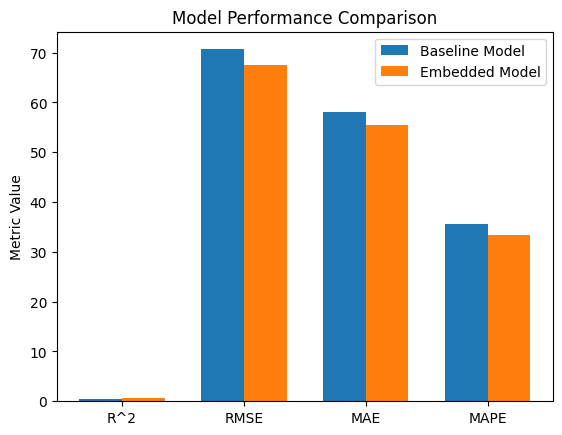

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Embeddings Model Metrics:
# RMSE: 70.67178279166752
# R^2: 0.5427826444677377
# MAE: 58.069601456649906
# MAPE: 35.50580237109067
# Baseline model metrics
baseline_metrics = {
    'R^2': 0.5427826444677377,
    'RMSE': 70.67178279166752,
    'MAE': 58.069601456649906,
    'MAPE': 35.50580237109067,
}

# Embeddings Model Metrics:
# RMSE: 67.52679252200055
# R^2: 0.5825707705276001
# MAE: 55.98161029819041
# MAPE: 34.09785381483837
# Embeddings model metrics
improved_metrics = {
    'R^2': 0.591229621476934,
    'RMSE':  67.52679252200055,
    'MAE': 55.41223211919878,
    'MAPE': 33.44460538721924,
}

# Metric names for the x-axis
metrics = list(baseline_metrics.keys())

# Metric values for the baseline and improved models
baseline_values = list(baseline_metrics.values())
improved_values = list(improved_metrics.values())

# Set the width of the bars
bar_width = 0.35

# Create the bar chart
fig, ax = plt.subplots()

# Bars for the baseline model
baseline_bars = ax.bar(np.arange(len(metrics)), baseline_values, bar_width, label='Baseline Model')

# Bars for the improved model
improved_bars = ax.bar(np.arange(len(metrics)) + bar_width, improved_values, bar_width, label='Embedded Model')

# Set the x-axis labels and tick positions
ax.set_xticks(np.arange(len(metrics)) + bar_width / 2)
ax.set_xticklabels(metrics)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the title of the chart
ax.set_title('Model Performance Comparison')

# Add a legend
ax.legend()

# Display the chart
plt.show()

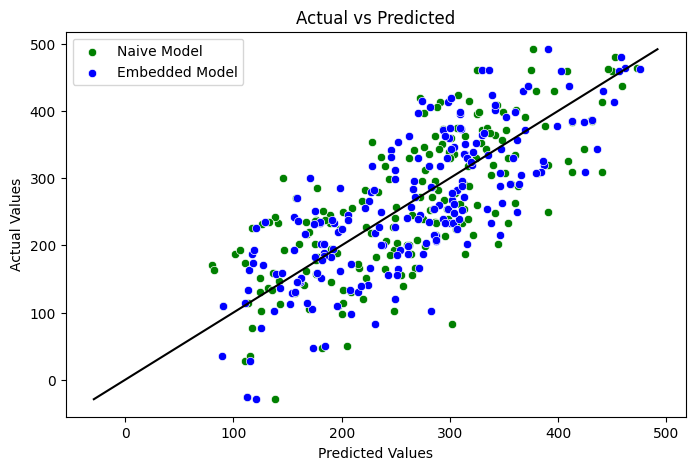

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatterplot for actual vs predicted values
fig, ax = plt.subplots(figsize=(8, 5))

# Plot naive model results in green
sns.scatterplot(x=y_pred_naive, y=y_test, ax=ax, color='green', label='Naive Model')

# Plot embedded model results in blue
sns.scatterplot(x=y_pred_emb, y=y_test, ax=ax, color='blue', label='Embedded Model')

# Plot the ideal line (y = x) in black
sns.lineplot(x=y_test, y=y_test, ax=ax, color='black')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.set_title('Actual vs Predicted')
ax.legend()

plt.show()